<IPython.core.display.Javascript object>


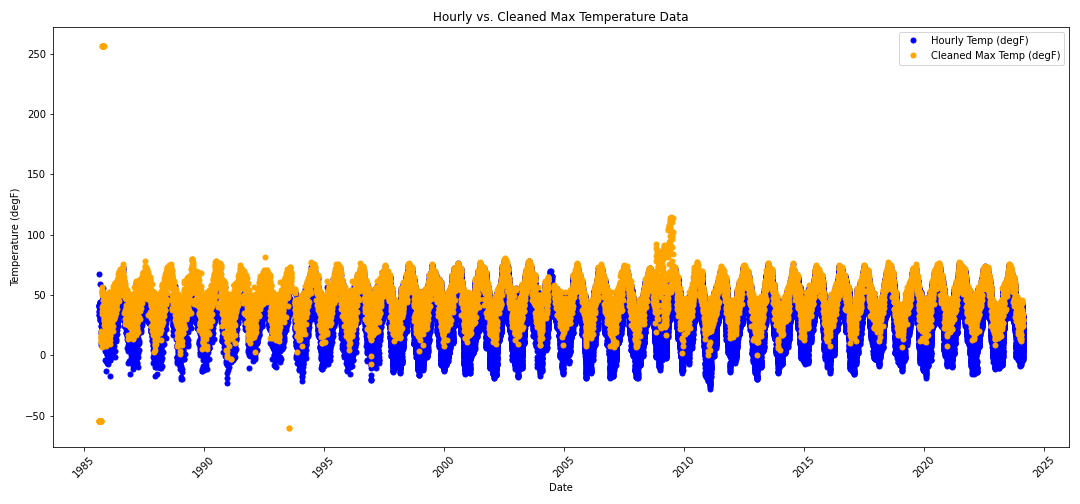

<IPython.core.display.Javascript object>


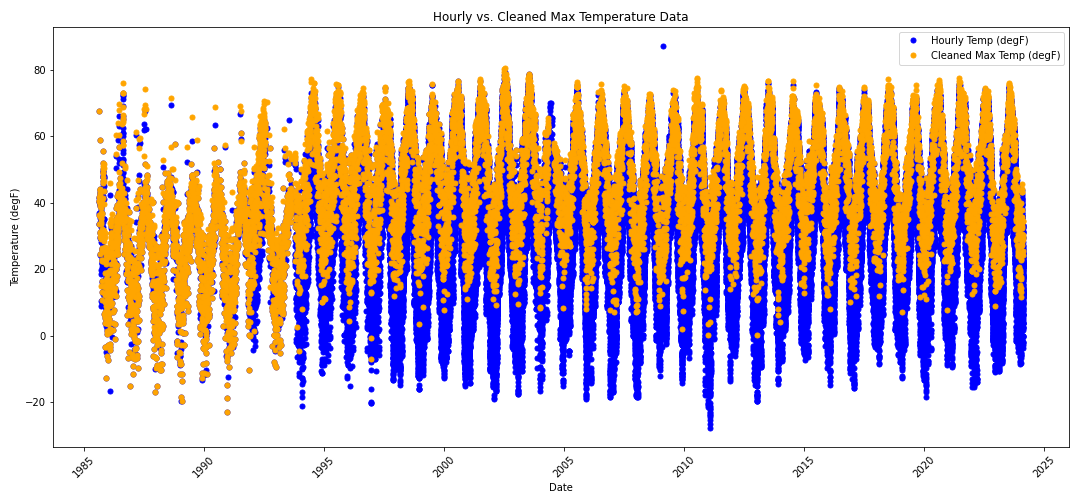

In [1]:
%matplotlib inline
%matplotlib notebook
import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interactive
import json
from datetime import datetime
import requests

#DATA FETCH
def fetch_awdb_data(station_triplets, begin_date, end_date, elements, duration):
    base_url = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/data"
    params = {
        "stationTriplets": station_triplets,
        "beginDate": begin_date,
        "endDate": end_date,
        "duration": duration,
        "elements": elements,
        "centralTendencyType": "NONE"
    }
    
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data: {response.status_code}")
        print(response.text)
        return None

def preprocess_data(data_json):
    if data_json:
        flat_data = [val for sublist in data_json[0]['data'] for val in sublist['values']]
        df = pd.DataFrame(flat_data)
        return df
            
station_triplets ="737:CO:SNTL"
begin_date = "1984-10-01 00:00"
end_date = "2024-02-16 00:00"

tobs_data_json = fetch_awdb_data(station_triplets, begin_date, end_date, "TOBS:*:1", "HOURLY")
tmax_data_json = fetch_awdb_data(station_triplets, begin_date, end_date, "TMAX:*:1", "DAILY")

if tobs_data_json is None or tmax_data_json is None:
    print("Failed to fetch data. Cannot proceed to data conversion.")
else:
    tobs_data = pd.DataFrame([item for sublist in tobs_data_json[0]['data'] for item in sublist['values']])
    tmax_data = pd.DataFrame([item for sublist in tmax_data_json[0]['data'] for item in sublist['values']])

#convert date columns and set as index
for df in [tobs_data, tmax_data]:
    df['date'] = pd.to_datetime(df['date'], errors = 'coerce')
    df.set_index('date', inplace = True)
    df['value'] = df['value'].astype(float)

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(tobs_data.index, tobs_data['value'], label = 'Hourly Temp (degF)', color = 'blue', marker ='o', linestyle='None', markersize=5)
plt.plot(tmax_data.index, tmax_data['value'], 'o', color='orange', markersize=5, label='Cleaned Max Temp (degF)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (degF)')
plt.title('Hourly vs. Cleaned Max Temperature Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def clean_data(max_temp_data, hourly_data, acceptable_range=10.0):
    hourly_data.index = pd.to_datetime(hourly_data.index).normalize()
    daily_max_hourly = hourly_data.resample('D').max()
    merged_data = pd.merge(max_temp_data, daily_max_hourly, left_index=True, right_index=True, how='left', suffixes=('_reported', '_calculated'))
    merged_data['diff'] = (merged_data['value_reported'] - merged_data['value_calculated']).abs()
    #Decide on handling based on threshold:
    merged_data['status'] = np.where(merged_data['diff'] <= acceptable_range, "Verfied", "Corrected")
    merged_data['value_final'] = np.where(merged_data['diff'] <= acceptable_range, merged_data['value_reported'], merged_data['value_calculated'])
    cleaned_df = df.dropna()
    return merged_data

tmax_data_cleaned = clean_data(tmax_data, tobs_data, 10.0)

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(tobs_data.index, tobs_data['value'], label = 'Hourly Temp (degF)', color = 'blue', marker ='o', linestyle='None', markersize=5)
plt.plot(tmax_data_cleaned.index, tmax_data_cleaned['value_final'], 'o', color='orange', markersize=5, label='Cleaned Max Temp (degF)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (degF)')
plt.title('Hourly vs. Cleaned Max Temperature Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the cleaned max temp data to a CSV file
tmax_data_cleaned[['value_calculated', 'value_reported', 'value_final', 'status']].to_csv('cleaned_max_temp_data.csv', index = True) 
